In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm
from sklearn.linear_model import Lasso
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys
import os
import pickle
from time import time

from numba import jit

In [2]:
sys.path.append(os.path.join("..", "utils"))
from synthetic_data import generate_synthetic_data

# Simulate syntehtic Data

In [3]:
sys.path.append(os.path.join("..", "data"))

In [59]:
# simulate the datas
data = generate_synthetic_data(p = 16, r = 8, n = 1000, rep=256)

criterion (2) : 0.8428421839247794


100%|███████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 479.12it/s]


In [4]:
with_save = False
if with_save:
    with open(os.path.join('..', 'data', 'critere_2_ok.pkl'), 'wb') as f:
        pickle.dump(data, f)

In [4]:
with open(os.path.join('..', 'data', 'critere_2_ok.pkl'), 'rb') as f:
    map_critere_ok = pickle.load(f)
with open(os.path.join('..', 'data', 'critere_2_non_ok.pkl'), 'rb') as f:
    map_critere_non_ok = pickle.load(f)

In [6]:
data = map_critere_ok.copy() 
# data = map_critere_non_ok.copy()

In [60]:
%%capture
# do the multiple lasso regressions
mu_range = np.exp(- np.linspace(0, 15, 50))
final_grid = np.zeros((16, 50))
for i in tqdm(range(256)):
    X, y = data["X"][i], data["Y"][i]
    for k in range(50):
        mu = mu_range[k]
        lasso_reg = Lasso(alpha=mu, max_iter=10000)
        lasso_reg.fit(X, y)
        coef = lasso_reg.coef_ 
        final_grid[:,k] += (coef != 0)*1
;

C:\Users\baptc\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


''

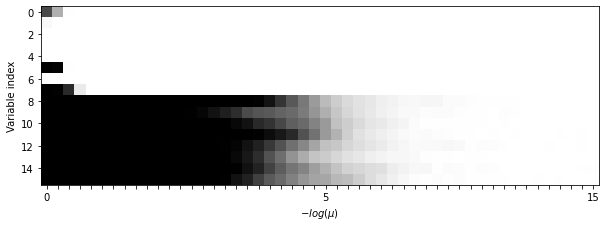

In [61]:
figure = plt.figure(figsize=(10,10))
plt.imshow(1 - final_grid / 256, cmap="Greys", vmin=0, vmax=1)
ax = plt.gca()

# the x-axis
ax.set_xticks(range(50))
ax.set_xlabel(np.linspace(0, 15, 50))
ax.set_xlabel("$-log(\mu)$")
d = dict(zip([0, 25, 49], [0, 5, 15]))
x_label_list = [str(d[i]) if i in [0, 25, 49] else str("") for i in range(50)]
ax.set_xticklabels(x_label_list)
ax.set_ylabel("Variable index")
;


In [62]:
from bolasso_algorithm import bolasso

In [ ]:
%%capture

nb_rep = 256
nb_mu = 50 # nu
m = 128

mu_range = np.exp(- np.linspace(0, 15, nb_mu))
final_grid = np.zeros((16, nb_mu))
for i in tqdm(range(nb_rep)):
    X, y = data["X"][i], data["Y"][i]
    for k in range(nb_mu):
        mu = mu_range[k]
        res = bolasso(X, y, m=m, mu=mu)
        coef = res["coef"] 
        final_grid[:,k] += (coef != 0)*1


In [7]:
%%capture

data_ok = map_critere_ok.copy() 

start = time()
nb_rep = 256
nb_mu = 50 # nu
m = 128

mu_range = np.exp(- np.linspace(0, 15, nb_mu))
final_grid_ok = np.zeros((16, nb_mu))

@jit(parallel=True)
def bolasso_it(X, y):   
    intermediate_grid = np.zeros((16, nb_mu))
    for k in range(nb_mu):
        mu = mu_range[k]
        res = bolasso(X, y, m=m, mu=mu)
        coef = res["coef"] 
        intermediate_grid[:,k] = (coef != 0)*1
    return intermediate_grid

list_grid_ok = []
list_X_ok = data_ok['X']
list_Y_ok = data_ok['Y']

for X, y in tqdm(zip(list_X_ok, list_Y_ok)):
    list_grid_ok.append(bolasso_it(X, y))
        
list_grid_ok = np.array(list_grid_ok)
final_grid_ok = np.sum(list_grid_ok, axis = 0)
end = time()

In [8]:
print(f"temps d'execution {end - start} , \ntemps par rep: {(end - start)/nb_rep}")

temps d'execution 5732.187886476517 , 
temps par rep: 22.391358931548893


In [ ]:
figure = plt.figure(figsize=(10,10))
plt.imshow(1 - final_grid_ok / nb_rep, cmap="Greys", vmin=0, vmax=1)
ax = plt.gca()

# the x-axis
ax.set_xticks(range(nb_mu))
ax.set_xlabel(np.linspace(0, 15, 10))
ax.set_xlabel("$-log(\mu)$")

d = dict(zip([0, 25, 49], [0, 5, 15]))

x_label_list = [str(d[i]) if i in [0, 25, 49] else str("") for i in range(nb_mu)]
ax.set_xticklabels(x_label_list)
ax.set_ylabel("Variable index")
;

In [14]:
%%capture

data_non_ok = map_critere_non_ok.copy() 

start = time()
nb_rep = 256
nb_mu = 50 # nu
m = 128

mu_range = np.exp(- np.linspace(0, 15, nb_mu))
final_grid_non_ok = np.zeros((16, nb_mu))

@jit(parallel=True)
def bolasso_it(X, y):   
    intermediate_grid = np.zeros((16, nb_mu))
    for k in range(nb_mu):
        mu = mu_range[k]
        res = bolasso(X, y, m=m, mu=mu)
        coef = res["coef"] 
        intermediate_grid[:,k] = (coef != 0)*1
    return intermediate_grid

list_grid_non_ok = []
list_X_non_ok = data_non_ok['X']
list_Y_non_ok = data_non_ok['Y']

for X, y in tqdm(zip(list_X_non_ok, list_Y_non_ok)):
    list_grid_non_ok.append(bolasso_it(X, y))
        
list_grid_non_ok = np.array(list_grid_non_ok)
final_grid_non_ok = np.sum(list_grid_non_ok, axis = 0)
end = time()

ValueError: Found array with 0 feature(s) (shape=(1000, 0)) while a minimum of 1 is required by LinearRegression.

In [11]:
print(f"temps d'execution {end - start} , \ntemps par rep: {(end - start)/nb_rep}")

temps d'execution -0.8667986392974854 , 
temps par rep: -0.003385932184755802


C:\Users\baptc\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


''

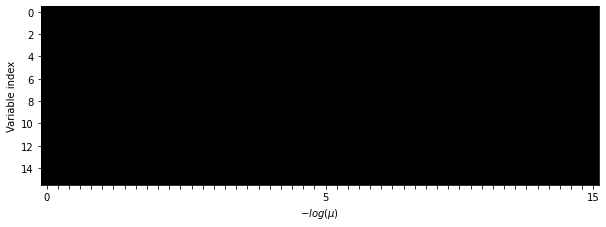

In [15]:
figure = plt.figure(figsize=(10,10))
plt.imshow(1 - final_grid_non_ok / nb_rep, cmap="Greys", vmin=0, vmax=1)
ax = plt.gca()

# the x-axis
ax.set_xticks(range(nb_mu))
ax.set_xlabel(np.linspace(0, 15, 10))
ax.set_xlabel("$-log(\mu)$")

d = dict(zip([0, 25, 49], [0, 5, 15]))

x_label_list = [str(d[i]) if i in [0, 25, 49] else str("") for i in range(nb_mu)]
ax.set_xticklabels(x_label_list)
ax.set_ylabel("Variable index")
;